In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.io as io
import scipy.signal as signal
from scipy.optimize import curve_fit
import logging
import importlib
import os


import ephys_extractor as efex
import ephys_features as ft
sns.set_style('whitegrid')

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

from sklearn import linear_model
ransac = linear_model.RANSACRegressor()

%matplotlib inline

In [2]:
# Normally you don't change modules though
importlib.reload(efex)
importlib.reload(ft)

<module 'ephys_features' from '/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py'>

# Load and process data

In [129]:
# L4 data .mat files
# Check out all directories with its subdirectories and files. Every step in the for-loop checks the root, all the
# subdirectories and the files in the current directory (with name root). Save the file if .mat extension.
L4 = []
L4_names = []
for root, dirs, files in os.walk('../L4/data/'):
    if files:
        for file in files:
            if file.endswith('.mat'):
                L4.append(io.loadmat(root + '/' + file))
                L4_names.append(root + '/' + file)

In [270]:
L4_names

['../L4/data/09 19 2018/09 19 2018 sample 7.mat',
 '../L4/data/09 19 2018/09 19 2018 sample 22.mat',
 '../L4/data/09 19 2018/09 19 2018 sample 8.mat',
 '../L4/data/09 19 2018/09 19 2018 sample 18.mat',
 '../L4/data/09 19 2018/09 19 2018 sample 19.mat',
 '../L4/data/09 19 2018/09 19 2018 sample 11.mat',
 '../L4/data/09 19 2018/09 19 2018 sample 2.mat',
 '../L4/data/09 19 2018/09 19 2018 sample 10.mat',
 '../L4/data/09 19 2018/09 19 2018 sample 16.mat',
 '../L4/data/09 19 2018/09 19 2018 sample 9.mat',
 '../L4/data/09 19 2018/09 19 2018 sample 25.mat',
 '../L4/data/09 19 2018/09 19 2018 sample 17.mat',
 '../L4/data/09 19 2018/09 19 2018 sample 14.mat',
 '../L4/data/09 19 2018/09 19 2018 sample 6.mat',
 '../L4/data/09 19 2018/09 19 2018 sample 3.mat',
 '../L4/data/09 19 2018/09 19 2018 sample 20.mat',
 '../L4/data/09 19 2018/09 19 2018 sample 15.mat',
 '../L4/data/09 19 2018/09 19 2018 sample 4.mat',
 '../L4/data/09 19 2018/09 19 2018 sample 13.mat',
 '../L4/data/09 19 2018/09 19 2018 sam

In [110]:
L4_re = []
L4_re_names = []
for root, dirs, files in os.walk('../L4/ReAnalysis/data/'):
    if files:
        for file in files:
            if file.endswith('.mat'):
                L4_re.append(io.loadmat(root + '/' + file))
                L4_re_names.append(root + '/' + file)

In [111]:
L4_re_names

['../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 21 09 slice 1 sample 6 (non-martinotti S1).mat',
 '../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 26 06 slice 1 sample 15 (non-martinotti S1).mat',
 '../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 26 06 slice 1 sample 16 (non-martinotti S1).mat',
 '../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 26 06 slice 1 sample 8 (non-martinotti S1).mat',
 '../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 21 09 slice 1 sample 8 (non-martinotti S1).mat',
 '../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 26 06 slice 1 sample 6 (non-martinotti S1).mat',
 '../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 05 06 slice 1 sample 16 (non-martinotti S1).mat',
 '../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 27 06 slice 1 sample 9 (non-martinotti S1).mat',
 '../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 19 09 slice 2 sample 23 (non-martinotti S1).mat',
 '../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 20 09

In [56]:
L4_excluded = []
L4_excluded_names = []
for root, dirs, files in os.walk('../L4/ReAnalysis/data/Excluded Data/'):
    if files:
        for file in files:
            if file.endswith('.mat'):
                L4_excluded.append(io.loadmat(root + '/' + file))
                L4_excluded_names.append(root + '/' + file)

In [5]:
def data_preparation(data, el_num = 2, current_step = 20):
    """Analyse the data in dictionary format (assumes a certain outlook of the data) and return the voltage traces, 
    stimulus current magnitudes for all traces, the time and the current index for which the current magnitude equals 0 pA.

    Parameters
    ----------
    data : dictionary full of voltage (V) and time (s) traces
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    
    Returns
    -------
    voltage : numpy 2D array of voltage traces (mV)
    time : numpy 1D array of time points (s)
    current : numpy 1D array of current stimulus magnitudes
    curr_index_0 : integer of current index where the current = 0 pA
    """
    
    
    
    # All the keys in the dictionary should have the form "Trace_1_j_c_el" where j represents a certain number which could
    # be different between cells/samples, therefore we will store this number as num. c represents the current stimulus
    # magnitude index, el the electrode number. They usually always record from electrode number el = 2.
    
    # Random initialisations
    num = 2
    n_samp = 22500
    dt = 4e-05
    for key in list(data)[1:6]:
        if key.split('_')[0] == "Trace":
            num = key.split('_')[2]
            n_samp = data[key].shape[0] # Amount of timepoints
            dt = data[key][1, 0] - data[key][0, 0] # Time step
            break
    time = np.arange(0,n_samp*dt,dt)
    
    # We pick random voltage traces to look for the resting membrane voltage
    Vm_tuple = []
    
    # Check whether we have hyperpolarisation in the beginning, otherwise the electrode where spikes have been recorded must have
    # been a different one
    object_ephys = efex.EphysSweepFeatureExtractor(t = time, v = 1000*data['Trace_{}_{}_{}_{}'.format(1, num, 1, el_num)][:, 1], \
                                                   start = 0.1, end = 0.7, filter = 10)
    voltage_deflection_v, _ = object_ephys.voltage_deflection()
    Vm = object_ephys._get_baseline_voltage()
    V_defl = voltage_deflection_v
    if  np.abs(Vm - V_defl) < 2:
        el_num = 1
        while np.abs(Vm - V_defl) < 2:
            object_ephys = efex.EphysSweepFeatureExtractor(t = time, v = 1000*data['Trace_{}_{}_{}_{}'.format(1, num, 1, el_num)][:, 1], \
                                                   start = 0.1, end = 0.7, filter = 10)
            Vm = object_ephys._get_baseline_voltage()
            V_defl, _ = object_ephys.voltage_deflection()
            if el_num == 1:
                el_num = 3
            else: el_num += 1
        el_num = el_num - 1
    #for i in np.arange(1, 12, 1):
    #    voltage_trace = data['Trace_1_{}_{}_{}'.format(num, i, el_num)][:, 1]
    #    object_ephys = efex.EphysSweepFeatureExtractor(t = time, v = 1000*voltage_trace, start = 0.1, end = 0.7, filter = 10)
    #    Vm = object_ephys._get_baseline_voltage()
    #    Vm_tuple.append(Vm)
    #Vm = np.mean(np.array(Vm_tuple))
    

    
    Amount_Of_Electrodes = np.max([int(g.split('_')[-1]) if (g.split('_')[0] == 'Trace') else 0 for g in list(data.keys())])
    
    # stim_paradigm_num is the number of current stimulus magnitudes that were used
    stim_paradigm_num = (np.array(list(data)).size - 3)/Amount_Of_Electrodes
                                    # 3 keys should just be '__globals__', '__header__', and '__version__'
    
    curr_index_0 = 0 # Current stimulus magnitude index that corresponds to stimulating the cell with 0 pA
    
    # Trace with the least amount of variance in the trace is assumed to be the trace corresponding to stimulating the cell
    # with 0 pA stimulation current
    best = np.var(1000*data['Trace_1_{}_{}_{}'.format(num, 1, el_num)][:, 1])
    #best = np.abs(np.mean(1000*data['Trace_1_{}_{}_{}'.format(num, 1, el_num)][:, 1]) - Vm)
    for i in np.arange(2, stim_paradigm_num + 1, 1, dtype = 'int'):
        best_temp = np.var(1000*data['Trace_1_{}_{}_{}'.format(num, i, el_num)][:, 1])
        #best_temp = np.abs(np.mean(1000*data['Trace_1_{}_{}_{}'.format(num, i, el_num)][:, 1]) - Vm)
        if  best_temp < best:
            best = best_temp
            curr_index_0 = i
    
    start_current_impulse = -(curr_index_0 - 1)*current_step # - 1 since in the dictionary we start at 1 (not at zero)    
    stop_current_impulse = start_current_impulse + (current_step*stim_paradigm_num)
    current = np.arange(start_current_impulse, stop_current_impulse, current_step)
    #current = current[current < 800] #After that the cell might die and it's probably innecessary for the analysis
    
    # voltage will give us the voltage response for all different current steps
    voltage = np.zeros((n_samp,len(current)))
    for c, C in enumerate(current):
        voltage[:,c] = 1000*data['Trace_1_{}_{}_{}'.format(num, c+1, el_num)][:,1] # c+1: goes from 1 to end of possible current
                                                                                   # stimulation magnitudes
    
    return time, current, voltage, (curr_index_0 - 1) # -1 since the current and voltage vector start at 0

In [320]:
data_NMC_1 = io.loadmat('../L4/data/06 27 2018/06 27 2018 sample 7.mat')
data_NMC_2 = io.loadmat('../L4/data/07 03 2018/07 03 2018 sample 8.mat')
data_NMC_3 = io.loadmat('../L4/data/07 05 2018/07 05 2018 sample 10.mat')
data_NMC_4 = io.loadmat('../L4/data/07 03 2018/07 03 2018 sample 18.mat')

In [348]:
data1 = io.loadmat('../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 04 06 slice 1 sample 1 (martinotti V1).mat')

In [317]:
data2 = io.loadmat('../L4/data/07 05 2018/07 05 2018 sample 5.mat')

In [96]:
data3 = io.loadmat('../L4/ReAnalysis/data/Excluded Data//2018 26 06 slice 1 sample 2 (non-martinoti S1).mat')

In [101]:
data4 = io.loadmat('../L4/ReAnalysis/data/Excluded Data//2018 05 06 slice 1 sample 17 (fast spiking S1).mat')

In [105]:
data5 = io.loadmat('../L4/ReAnalysis/data/Excluded Data//2018 06 06 slice 1 sample 1.mat')

In [32]:
DATA = io.loadmat('../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 20 09 slice 1 sample 11 (martinotti V1).mat')

In [45]:
DATA_1 = io.loadmat('../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 19 09 slice 1 sample 1 (martinotti V1).mat')

In [56]:
DATA_2 = io.loadmat('../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 05 06 slice 1 sample 13 (non-martinotti S1).mat')

In [86]:
DATA_3 = io.loadmat('../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 26 06 slice 1 sample 12 (martinotti V1).mat')

In [87]:
time, current, voltage, curr_index_0 = data_preparation(DATA_3, el_num = 2)
print('time: ', time)
print('\n\ncurrent: ', current)
print('\n\nvoltage: ', voltage)
print('\n\ncurr_index_0: ', curr_index_0)

time:  [0.0000e+00 4.0000e-05 8.0000e-05 ... 8.9988e-01 8.9992e-01 8.9996e-01]


current:  [-200. -180. -160. -140. -120. -100.  -80.  -60.  -40.  -20.    0.   20.
   40.   60.   80.  100.  120.  140.  160.  180.  200.  220.  240.  260.
  280.  300.  320.  340.  360.  380.  400.  420.  440.  460.  480.  500.
  520.  540.  560.  580.  600.  620.  640.  660.  680.  700.  720.  740.
  760.  780.  800.  820.  840.  860.  880.  900.  920.  940.  960.  980.
 1000. 1020. 1040. 1060. 1080. 1100. 1120. 1140. 1160. 1180. 1200. 1220.
 1240. 1260. 1280. 1300. 1320. 1340. 1360. 1380.]


voltage:  [[-56.9039844  -54.9855046  -53.95350233 ... -66.73520803 -66.65320694
  -66.56369567]
 [-56.90573156 -54.96731028 -53.98320407 ... -66.73693657 -66.68520719
  -66.56633317]
 [-56.90789223 -54.95039374 -54.01271209 ... -66.73745811 -66.71563536
  -66.56878442]
 ...
 [-47.7858521  -45.78780383 -50.46089739 ... -65.1999712  -65.17465413
  -65.41471928]
 [-47.78897762 -45.78306153 -50.48773438 ... -65.2257427

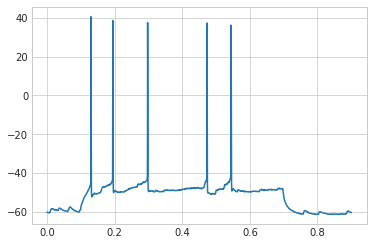

In [40]:
plt.plot(time, voltage[:, 12])

In [380]:
ft.find_time_index(time, 0.11)

2750

Text(0.5,1,'Raw voltage trace')

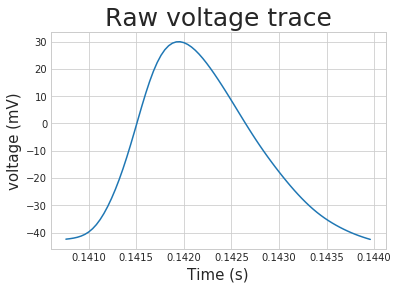

In [378]:
plt.plot(time[3519:3600], voltage[3519:3600, 11])
plt.xlabel('Time (s)', fontsize = 15)
plt.ylabel('voltage (mV)', fontsize = 15)
plt.title('Raw voltage trace', fontsize = 25)
#plt.savefig('L5NMC4.png')

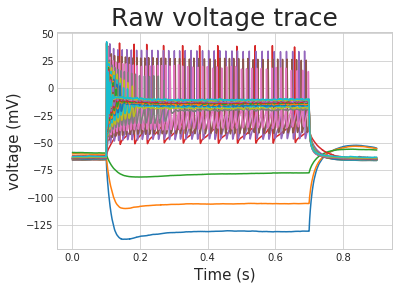

In [316]:
plt.plot(time, voltage[:, ::4])
plt.xlabel('Time (s)', fontsize = 15)
plt.ylabel('voltage (mV)', fontsize = 15)
plt.title('Raw voltage trace', fontsize = 25)
plt.savefig('L5MC.png')

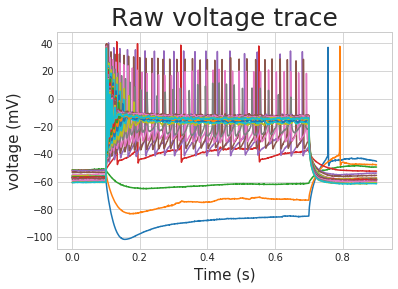

In [319]:
plt.plot(time, voltage[:, ::4])
plt.xlabel('Time (s)', fontsize = 15)
plt.ylabel('voltage (mV)', fontsize = 15)
plt.title('Raw voltage trace', fontsize = 25)
plt.savefig('L5MC1.png')

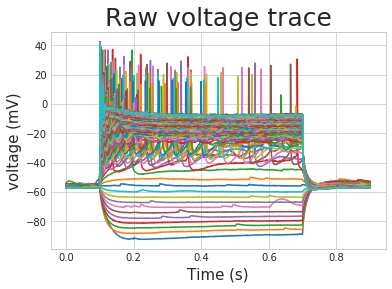

In [100]:
plt.plot(time, voltage)
plt.xlabel('Time (s)', fontsize = 15)
plt.ylabel('voltage (mV)', fontsize = 15)
plt.title('Raw voltage trace', fontsize = 25)
plt.savefig('Example3.png')

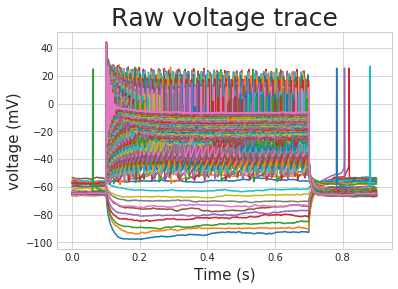

In [107]:
plt.plot(time, voltage)
plt.xlabel('Time (s)', fontsize = 15)
plt.ylabel('voltage (mV)', fontsize = 15)
plt.title('Raw voltage trace', fontsize = 25)
plt.savefig('Example4.png')

In [210]:
dvdt = ft.calculate_dvdt(voltage[:, 16], time)

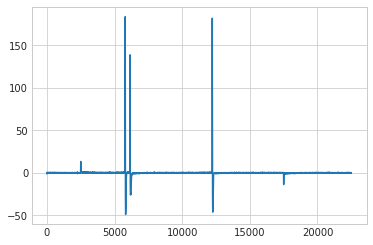

In [211]:
plt.plot(dvdt)

In [70]:
time_asc, current_asc, voltage_asc, curr_index_0_asc = data_preparation_asc('../M1/L5/01 02 2018/01 02 2018 sample 1.asc', \
                                                            '../M1/L5/01 02 2018/sample1splitfiles/')
print('time: ', time_asc)
print('\n\ncurrent: ', current_asc)
print('\n\nvoltage: ', voltage_asc)
print('\n\ncurr_index_0 ', curr_index_0_asc)

time:  [0.0000e+00 4.0000e-05 8.0000e-05 ... 8.9988e-01 8.9992e-01 8.9996e-01]


current:  [-200 -180 -160 -140 -120 -100  -80  -60  -40  -20    0   20   40   60
   80  100  120  140  160  180  200  220  240  260  280  300  320  340
  360  380  400  420  440  460  480  500  520  540  560  580]


voltage:  [[-63.26682866 -61.4560023  -60.96274033 ... -68.39887053 -68.37533414
  -68.57176125]
 [-63.28312308 -61.46592274 -60.94012037 ... -68.37874651 -68.39634478
  -68.57612729]
 [-63.30004334 -61.47384271 -60.91597304 ... -68.35854799 -68.41933727
  -68.58035922]
 ...
 [-58.7365441  -58.89197811 -58.74111876 ... -68.07727367 -68.23767722
  -68.32093745]
 [-58.73662233 -58.89251828 -58.72721598 ... -68.07102263 -68.25365871
  -68.33034754]
 [-58.7377362  -58.89437348 -58.71508271 ... -68.0674836  -68.26816499
  -68.3369413 ]]


curr_index_0  10


# Analysing spikes

In [6]:
def extract_spike_features(time, current, voltage, start = 0.1, end = 0.7, fil = 10):
    """ Analyse the voltage traces and extract information for every spike (returned in df), and information for all the spikes
    per current stimulus magnitude.

    Parameters
    ----------
    time : numpy 1D array of the time (s)
    current : numpy 1D array of all possible current stimulation magnitudes (pA)
    voltage : numpy ND array of all voltage traces (mV) corresponding to current stimulation magnitudes
    start : start of the stimulation (s) in the voltage trace (optional, default 0.1)
    end : end of the stimulation (s) in the voltage trace (optional, default 0.7)
    fil : cutoff frequency for 4-pole low-pass Bessel filter in kHz (optional, default 10)
    
    Returns
    -------
    df : DataFrame with information for every detected spike (peak_v, peak_index, threshold_v, ...)
    df_related_features : DataFrame with information for every possible used current stimulation magnitude
    """
    
    df = pd.DataFrame()
    df_related_features = pd.DataFrame()
    for c, curr in enumerate(current):
        current_array = curr*np.ones_like(time)
        start_index = (np.abs(time - start)).argmin() # Find closest index where the injection current starts
        end_index = (np.abs(time - end)).argmin() # Find closest index where the injection current ends
        current_array[:start_index] = 0
        current_array[end_index:len(current_array)] = 0
        EphysObject = efex.EphysSweepFeatureExtractor(t = time, v = voltage[:, c], i = current_array, start = start, \
                                                      end = end, filter = fil)
        EphysObject.process_spikes()
        #if EphysObject._spikes_df.size:
        #    #Random threshold 15 for now but:
        #    if np.abs(EphysObject._get_baseline_voltage() - np.mean(EphysObject._spikes_df['threshold_v'].values)) < 15:
        #        print('Too steep depolarisation here.')
        #        EphysObject = efex.EphysSweepFeatureExtractor(t = time, v = voltage[:, c], i = current_array, start = 0.1005, \
        #                                                     end = end, filter = fil)
        
        # Adding peak_height (mV) + code for maximum frequency determination (see further)
        spike_count = 0
        if EphysObject._spikes_df.size:
            EphysObject._spikes_df['peak_height'] = EphysObject._spikes_df['peak_v'].values - \
                                                   EphysObject._spikes_df['threshold_v'].values
            spike_count = EphysObject._spikes_df['threshold_i'].values.size
        df = pd.concat([df, EphysObject._spikes_df])

        # Some easily found extra features
        df_features = EphysObject._sweep_features

        # Adding spike count
        df_features.update({'spike_count': spike_count})
        
        # Adding current (pA)
        df_features.update({'current': curr})

        # Adding membrane voltage (mV)
        df_features.update({'resting_membrane_potential': EphysObject._get_baseline_voltage()})

        # Adding voltage deflection (mV)
        voltage_deflection_v, voltage_deflection_i = EphysObject.voltage_deflection()
        df_features.update({'voltage_deflection': voltage_deflection_v})
        
        # Adding input resistance (MOhm)
        # How to calculate the input resistance is not clear yet but this could be an option (although in function
        # get_cell_features it is being calculated differently)
        input_resistance = np.nan
        if not ('peak_i' in EphysObject._spikes_df.keys()) and not curr==0: # We only calculate input resistances 
                                                                            # from traces without peaks
            input_resistance = (np.abs(voltage_deflection_v - EphysObject._get_baseline_voltage())*1000)/np.abs(curr)
            if input_resistance == np.inf:
                input_resistance = np.nan
        df_features.update({'input_resistance': input_resistance})

        # Adding membrane time constant (s) and voltage plateau level for hyperpolarisation paradigms after stimulus onset
        tau = np.nan
        E_plat = np.nan
        sag = np.nan
        if curr < 0: # We use hyperpolarising steps as required in the object function to estimate the membrane time constant
                     # and E_plateau
            tau = EphysObject.estimate_time_constant()  # Result in seconds!
            E_plat = ft.average_voltage(voltage[:, c], time, start = end - 0.1, end = end)
            sag, sag_ratio = EphysObject.estimate_sag()
        df_features.update({'tau': tau})
        df_features.update({'E_plat': E_plat})
        df_features.update({'sag': sag})

        df_related_features = pd.concat([df_related_features, pd.DataFrame([df_features])])
    
    return df, df_related_features

In [88]:
df, df_related_features = extract_spike_features(time, current, voltage)

/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


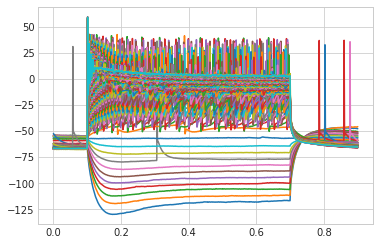

In [89]:
plt.plot(time, voltage)

In [83]:
df_related_features

,E_plat,adapt,adaptation_index,avg_rate,current,first_isi,input_resistance,isi_cv,latency,mean_isi,median_isi,resting_membrane_potential,sag,spike_count,tau,v_baseline,voltage_deflection
0,-115.491721,NaN,NaN,0.000000,-280.0,NaN,275.219545,NaN,NaN,NaN,NaN,-50.165402,0.150077,0,0.019868,-50.165402,-127.226874
0,-109.986785,NaN,NaN,0.000000,-260.0,NaN,256.382272,NaN,NaN,NaN,NaN,-48.240759,0.072552,0,0.021858,-48.240759,-114.900149
0,-106.336324,NaN,NaN,0.000000,-240.0,NaN,260.174251,NaN,NaN,NaN,NaN,-47.957918,0.063149,0,0.021742,-47.957918,-110.399738
0,-101.292776,NaN,NaN,0.000000,-220.0,NaN,269.889171,NaN,NaN,NaN,NaN,-47.464382,0.090375,0,0.027839,-47.464382,-106.840000
0,-99.253313,NaN,NaN,0.000000,-200.0,NaN,270.769497,NaN,NaN,NaN,NaN,-48.419205,0.059185,0,0.032532,-48.419205,-102.573104
0,-94.431283,NaN,NaN,0.000000,-180.0,NaN,272.210871,NaN,NaN,NaN,NaN,-48.450795,0.059315,0,0.024490,-48.450795,-97.448751
0,-90.284653,NaN,NaN,0.000000,-160.0,NaN,270.979966,NaN,NaN,NaN,NaN,-47.826637,0.018454,0,0.026043,-47.826637,-91.183431
0,-85.312306,NaN,NaN,0.000000,-140.0,NaN,294.153550,NaN,NaN,NaN,NaN,-47.470749,0.078458,0,0.023833,-47.470749,-88.652246
0,-81.950123,NaN,NaN,0.000000,-120.0,NaN,292.484226,NaN,NaN,NaN,NaN,-47.335251,0.011527,0,0.023838,-47.335251,-82.433358
0,-76.275725,NaN,NaN,0.000000,-100.0,NaN,288.681048,NaN,NaN,NaN,NaN,-48.188616,-0.030646,0,0.019672,-48.188616,-77.056721


In [85]:
df

,threshold_index,clipped,peak_index,peak_t,peak_v,peak_i,threshold_t,threshold_v,threshold_i,trough_index,...,fast_trough_t,fast_trough_v,fast_trough_i,adp_index,adp_t,adp_v,adp_i,width,upstroke_downstroke_ratio,peak_height
0,12199,False,12223,0.48892,19.269116,-20.0,0.48796,-46.588242,-20.0,12865,...,0.49520,-54.725714,-20.0,NaN,NaN,NaN,NaN,0.00120,2.433088,65.857358
0,4866,False,4891,0.19564,17.616555,0.0,0.19464,-45.032181,0.0,5280,...,0.20200,-53.243861,0.0,NaN,NaN,NaN,NaN,0.00124,2.488007,62.648736
0,2574,False,2599,0.10396,20.194376,20.0,0.10296,-46.738740,20.0,2871,...,0.10916,-52.869905,20.0,NaN,NaN,NaN,NaN,0.00124,2.459182,66.933116
1,3762,False,3787,0.15148,16.993962,20.0,0.15048,-44.151265,20.0,4124,...,0.15840,-52.838583,20.0,NaN,NaN,NaN,NaN,0.00128,2.472167,61.145227
2,9164,False,9190,0.36760,14.333929,20.0,0.36656,-42.559445,20.0,9445,...,0.37384,-50.963383,20.0,NaN,NaN,NaN,NaN,0.00132,2.348388,56.893374
3,12571,False,12598,0.50392,15.869370,20.0,0.50284,-44.058509,20.0,12895,...,0.51148,-52.820738,20.0,NaN,NaN,NaN,NaN,0.00132,2.407247,59.927879
4,13729,False,13754,0.55016,16.585892,20.0,0.54916,-44.554304,20.0,14047,...,0.55692,-52.205700,20.0,NaN,NaN,NaN,NaN,0.00132,2.520890,61.140196


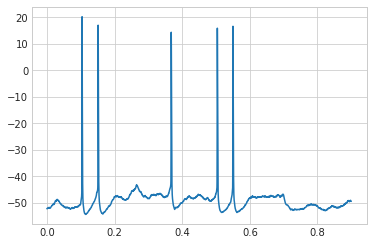

In [84]:
plt.plot(time, voltage[:, -1])

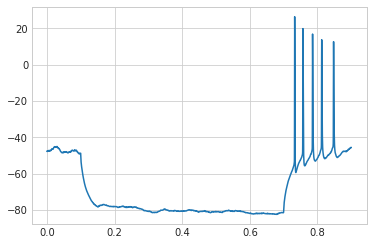

In [53]:
#DATA_1
plt.plot(time, voltage[:, 8])

In [145]:
df.keys()

Index(['threshold_index', 'clipped', 'threshold_t', 'threshold_v',
       'threshold_i', 'trough_index', 'trough_t', 'trough_v', 'trough_i',
       'peak_index', 'peak_t', 'peak_v', 'peak_i', 'downstroke_index',
       'downstroke', 'downstroke_t', 'downstroke_v', 'upstroke_index',
       'upstroke', 'upstroke_t', 'upstroke_v', 'isi_type', 'fast_trough_index',
       'fast_trough_t', 'fast_trough_v', 'fast_trough_i', 'slow_trough_index',
       'slow_trough_t', 'slow_trough_v', 'slow_trough_i', 'adp_index', 'adp_t',
       'adp_v', 'adp_i', 'width', 'upstroke_downstroke_ratio', 'peak_height'],
      dtype='object')

In [248]:
np.nonzero(df_related_features['spike_count'].values)[0]

array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
       28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
       45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
       62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,
       79])

In [90]:
def get_cell_features(df, df_related_features, curr_index_0, current_step = 20):
    """ Analyse all the features available for the cell per spike and per current stimulation magnitude. Extract typical
    features includig the resting membrane potential (Rm, mV), the input resistance (Ri, MOhm), the membrane time constant
    (tau, ms), the action potential threshold (AP threshold, mV), the action potential amplitude (AP amplitude, mV),
    the action potential half-width (AP half-width, ms), the afterhyperpolarisation (AHP, mV), the afterdepolarisation
    (ADP, mV), the adaptation index (AI, %) and the maximum firing frequency (max freq, Hz).
    
    Parameters
    ----------
    df : DataFrame with information for every detected spike
    df_related_features : DataFrame with information for every possible used current stimulation magnitude
    curr_index_0 : integer of current index where the current = 0 pA
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    Returns
    ----------
    Cell_Features : DataFrame with values for all required features mentioned above
    """

    # We consider all hyperpolarisation traces but perform an average without outliers (outliers are defined as lying above
    # or below 2 standard deviations from the mean) for tau, the resting membrane potential and the input resistance
    tau_array = df_related_features['tau'].dropna().values
    Rm_array = df_related_features['resting_membrane_potential'][:curr_index_0 + 1].dropna().values
    Ri_array = df_related_features['input_resistance'].dropna().values
    sag_array = df_related_features['sag'].dropna().values
    
    mean_tau = np.mean(tau_array, axis = 0)
    mean_Rm = np.mean(Rm_array, axis = 0)
    mean_Ri = np.mean(Ri_array, axis = 0)
    mean_sag = np.mean(sag_array, axis = 0)
    
    sd_tau = np.std(tau_array, axis = 0)
    sd_Rm = np.std(Rm_array, axis = 0)
    sd_Ri = np.std(Ri_array, axis = 0)
    sd_sag = np.std(sag_array, axis = 0)

    tau_array_non_outliers = [x for x in tau_array if (x > mean_tau - 2*sd_tau)]
    Rm_array_non_outliers = [x for x in Rm_array if (x > mean_Rm - 2*sd_Rm)]
    Ri_array_non_outliers = [x for x in Ri_array if (x > mean_Ri - 2*sd_Ri)]
    sag_array_non_outliers = [x for x in sag_array if (x > mean_sag - 2*sd_sag)]
    tau_array_non_outliers = [x for x in tau_array_non_outliers if (x < mean_tau + 2*sd_tau)]
    Rm_array_non_outliers = [x for x in Rm_array_non_outliers if (x < mean_Rm + 2*sd_Rm)]
    Ri_array_non_outliers = [x for x in Ri_array_non_outliers if (x < mean_Ri + 2*sd_Ri)]
    sag_array_non_outliers = [x for x in sag_array_non_outliers if (x < mean_sag + 2*sd_sag)]
    
    tau = np.mean(np.array(tau_array_non_outliers))*1000
    Rm = np.mean(np.array(Rm_array_non_outliers))
    Ri = np.mean(np.array(Ri_array_non_outliers))
    sag = np.mean(np.array(sag_array_non_outliers))
    
    if not df.empty:
        max_freq = np.max(df_related_features['spike_count'].values)
        
        non_nan_indexes_AI = ~np.isnan(df_related_features['adaptation_index'].values)
        
        #rheobase_2 = df_related_features['current'].values[np.nonzero(df_related_features['spike_count'].values)[0][0]]
        #if rheobase_2 < 0: # For this experimental paradigm, no negative currents can cause spikes
        #    rheobase_2 = 0
        #print('rheobase_2 (pA): ', rheobase_2)
        if non_nan_indexes_AI.any():
            # We need an AI where the current is positive and non-NaN (for these experimental paradigms)
            index_df_related_features = np.max([np.flatnonzero(df_related_features['current'].values > 0)[0], \
                                                np.flatnonzero(~np.isnan(df_related_features['adaptation_index'].values))[0]])
            AI = df_related_features['adaptation_index'].values[index_df_related_features]
        else:
            AI = 0
            
        # First index where there is a spike and the current stimulation magnitude is positive
        index_df =  np.where(df.loc[0]['fast_trough_i'].values > 0)[0][0]
        
        non_nan_indexes_ahp = ~np.isnan(df.loc[0]['fast_trough_v'])
        if non_nan_indexes_ahp.any():
            AHP = df.loc[0]['fast_trough_v'].values[index_df] - df.loc[0]['threshold_v'].values[index_df]
            # Only first peak is considered
            
            #valid_indexes = AHP_fast < 0
            # This excludes the possible strange appearing thresholds for the peaks towards high
            #                     # stimulation current magnitudes
            #AHP = np.nanmean(AHP_fast[valid_indexes])
        else:
            AHP = 0
    
        # ADP (after changing a threshold delta_t (i.e. ADP should be shorter in time than this value): by default value set
        # in ephys_features.py from 0.005 to 0.01 !!!!!!!!!!)
        # Calculated w.r.t. AHP index!!!
        non_nan_indexes_adp = ~np.isnan(df.loc[0]['adp_v'])
        if non_nan_indexes_adp.any():
            ADP = df.loc[0]['adp_v'].values[index_df] - df.loc[0]['fast_trough_v'].values[index_df] # Only first peak is considered
            #valid_indexes = ADP_values > 0 # Will also make the Nan's false but we can still
            #          #do np.nanmean in the end
            #ADP = np.nanmean(ADP_values)
        else:
            ADP = 0
        non_nan_indexes_thresh = ~np.isnan(df.loc[0]['threshold_v'])
        if non_nan_indexes_thresh.any():
            if df.loc[0]['threshold_v'].size > 1:
                AP_threshold = df.loc[0]['threshold_v'].values[index_df] # Only first peak is considered
                AP_amplitude = df.loc[0]['peak_height'].values[index_df] # Only first peak is considered
                AP_half_width = 1000*df.loc[0]['width'].values[index_df] # Only first peak is considered
            else:
                AP_threshold = df.loc[0]['threshold_v'] # Only first peak is considered
                AP_amplitude = df.loc[0]['peak_height'] # Only first peak is considered
                AP_half_width = 1000*df.loc[0]['width'] # Only first peak is considered

        else:
            AP_threshold = 0
            AP_amplitude = 0
            AP_half_width = 0
        
        # We estimate the rheobase based on a few (i.e. 5)
        # suprathreshold currents steps. A linear fit of the spike frequency w.r.t. to the current injection values of
        # these steps should give the rheobase as the crossing with the x-axis. (Method almost in agreement with Alexandra
        # Naka et al.: "Complementary networks of cortical somatostatin interneurons enforce layer specific control.", 
        # they additionally use the subthreshold current step closest to the first suprathreshold one, we think that biases
        # the regression analysis). We take the max of the subthreshold current step closest to the
        # suprathreshold one and the regression line crossing with the x-axis. This method should approximate the rheobase
        # well provided the stimulus interval is long (in our case 600 ms).
        # If a regression cannot be performed, then take the first current step for which spikes have been observed (i.e.
        # not the subthreshold current step!)
        
        # Only positive currents for this experimental paradigm (i.e. 'spikes' observed for negative currents should not
        # be there)
        df_rheobase = df_related_features[['current', 'spike_count']][df_related_features['current'] >= 0]
        if len(np.nonzero(df_rheobase['spike_count'].values)[0]) > 4:
            indices = np.nonzero(df_rheobase['spike_count'].values)[0][:5]
            counts = [list(df_rheobase['spike_count'].values[indices]).count(x) for x in \
                                          df_rheobase['spike_count'].values[indices]]
            if np.max(np.array(counts)) < 3:
                ransac.fit(df_rheobase['current'].values[indices].reshape(-1, 1), \
                           df_rheobase['spike_count'].values[indices].reshape(-1, 1)/(0.6))
                line_X = np.concatenate((df_rheobase['current'].values[indices], \
                                         np.array([0]))).reshape(-1, 1)
                slope = ransac.estimator_.coef_[0][0]
                sub_thresh_curr = df_rheobase['current'].values\
                    [np.nonzero(df_rheobase['spike_count'].values)[0][0] - 1]
                first_supra_thresh_curr = df_rheobase['current'].values\
                    [np.nonzero(df_rheobase['spike_count'].values)[0][0]]
                rheobase = np.max([-ransac.predict(np.array([0]).reshape(-1, 1))[0][0]/slope, sub_thresh_curr])
                rheobase = np.min([rheobase, first_supra_thresh_curr])
                plt.plot(df_rheobase['current'].values[indices].reshape(-1, 1), \
                         df_rheobase['spike_count'].values[indices].reshape(-1, 1)/(0.6), '.m')
                plt.plot(line_X, ransac.predict(line_X))
                plt.legend(['data', 'regression robust to outliers'])
                plt.xlim([-20, 400])
                plt.xlabel('current (pA)')
                plt.ylabel('spike frequency (Hz)')
                plt.title('regression analysis')
            else: # A subset can probably not be found by RANSAC to do a regression
                  # Just take the first current step for which spikes have been observed
                rheobase = df_rheobase['current'].values\
                                [np.nonzero(df_rheobase['spike_count'].values)[0][0]]

        else: # Not enough datapoints to calculate a rheobase
              # Just take the first current step for which spikes have been observed
            rheobase = df_rheobase['current'].values\
                            [np.nonzero(df_rheobase['spike_count'].values)[0][0]]
        
    else:
        AHP = 0
        ADP = 0
        max_freq = 0
        AI = 0
        AP_threshold = 0
        AP_amplitude = 0
        AP_half_width = 0
        rheobase = 0
    
    name_features = ['Rm (mV)', 'Input res (MOhm)', 'tau (ms)', 'AP threshold (mV)', 'AP amplitude (mV)', 'AP half-width (ms)', \
                 'AHP (mV)', 'ADP (mV)', 'AI (%)', 'MAX freq', 'rheobase (pA)', 'sag']
    features = [Rm, Ri, tau, AP_threshold, AP_amplitude, AP_half_width, AHP, ADP, AI, max_freq, rheobase, sag]
    cell_features = dict(zip(name_features, features))
    Cell_Features = pd.DataFrame([cell_features])
    Cell_Features = Cell_Features.reindex(columns = name_features)
    return Cell_Features

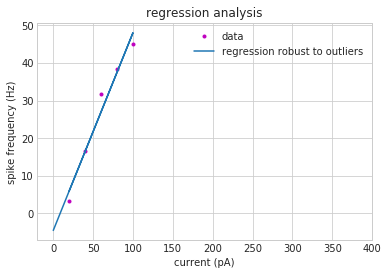

In [91]:
Cell_Features = get_cell_features(df, df_related_features, curr_index_0)

In [92]:
Cell_Features

,Rm (mV),Input res (MOhm),tau (ms),AP threshold (mV),AP amplitude (mV),AP half-width (ms),AHP (mV),ADP (mV),AI (%),MAX freq,rheobase (pA),sag
0,-55.38589,378.794008,22.052209,-40.724415,83.10556,0.72,-12.356274,4.031472,105.484461,33,8.571429,0.113584


In [8]:
def cell_features(data_tuple, names, el_num = 2, current_step = 20):
    """ Analyses a stream of cell dictionaries and outputs all the cell's features in a concatenated DataFrame
    Parameters
    ----------
    data_tuple : tuple of dictionaries of data full of voltage (V) and time (s) traces for different cells
    names : tuple of names of the samples
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    
    Returns
    -------
    All_Cells_Features : DataFrame with values for all required features mentioned in get_cell_features
    """
    All_Cells_Features = pd.DataFrame()
    for (data, name) in zip(data_tuple, names):
        print('Processing: ', name)
        time, current, voltage, curr_index_0 = data_preparation(data)
        filter_ = 10
        if (1/time[1]-time[0]) < 20e3:
            filter_ = (1/time[1]-time[0])/(1e3*2)-0.5
        df, df_related_features = extract_spike_features(time, current, voltage)
        Cell_Features = get_cell_features(df, df_related_features, curr_index_0)
        All_Cells_Features = pd.concat([All_Cells_Features, Cell_Features])
    All_Cells_Features.insert(0, 'name sample', names)
    return All_Cells_Features.fillna(0)       # Nan values can be considered as 0 for AHP, ADP, ... (rheobase??!!)

In [26]:
All_Cells_Features_L4 = cell_features(L4, L4_names)
All_Cells_Features_L4.to_csv('../L4/L4Data/Cell_Features_L5_analysis.csv')

NameError: name 'L4' is not defined

Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 21 09 slice 1 sample 6 (non-martinotti S1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 26 06 slice 1 sample 15 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 26 06 slice 1 sample 16 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 26 06 slice 1 sample 8 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 21 09 slice 1 sample 8 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 26 06 slice 1 sample 6 (non-martinotti S1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 05 06 slice 1 sample 16 (non-martinotti S1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 27 06 slice 1 sample 9 (non-martinotti S1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 19 09 slice 2 sample 23 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 20 09 slice 1 sample 9 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 26 06 slice 1 sample 7 (maps to PV).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 19 09 slice 2 sample 14 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 19 09 slice 2 sample 20 (non-martinotti S1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 05 06 slice 1 sample 14 (non-martinotti S1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 21 09 slice 1 sample 4 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 26 06 slice 1 sample 2 (non-martinotti S1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 19 09 slice 1 sample 17 (non-martinotti S1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 27 06 slice 1 sample 1 (maps to PV).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 21 09 slice 1 sample 5 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 19 09 slice 2 sample 18 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 19 09 slice 2 sample 24 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 19 09 slice 2 sample 22 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 05 06 slice 1 sample 15 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 19 09 slice 2 sample 19 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 21 09 slice 1 sample 3 (non-martinotti S1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 21 09 slice 1 sample 2 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 05 06 slice 1 sample 17 (maps to PV).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 20 09 slice 1 sample 10 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 26 06 slice 1 sample 17 (non-martinotti S1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 19 09 slice 2 sample 21 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 03 07 slice 1 sample 14 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 27 06 slice 1 sample 8 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 03 07 slice 1 sample 11 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 27 06 slice 1 sample 3 (non-martinotti S1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 19 09 slice 1 sample 7 (non-martinotti S1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 19 09 slice 1 sample 15 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 05 07 slice 1 sample 6 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 21 09 slice 1 sample 1 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 03 07 slice 1 sample 7 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 05 06 slice 1 sample 18 (non-martinotti S1).mat
Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 19 09 slice 1 sample 10 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 20 09 slice 1 sample 11 (martinotti V1).mat
Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 05 06 slice 1 sample 1 (martinotti V1).mat
Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 20 09 slice 1 sample 4 (martinotti V1).mat
Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 19 09 slice 1 sample 1 (martinotti V1).mat
Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 05 06 slice 1 sample 13 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 03 07 slice 1 sample 15 (martinotti V1).mat
Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 26 06 slice 1 sample 13 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 05 07 slice 1 sample 2 (martinotti V1).mat
Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 19 09 slice 1 sample 11 (martinotti V1).mat
Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 19 09 slice 2 sample 13 (martinotti V1).mat
Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 20 09 slice 1 sample 3 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 03 07 slice 1 sample 2 (martinotti V1).mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 19 09 slice 1 sample 9 (martinotti V1).mat
Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 19 09 slice 2 sample 16 (martinotti V1).mat
Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 04 06 slice 1 sample 2 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 05 06 slice 1 sample 5 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 26 06 slice 1 sample 12 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 19 09 slice 1 sample 2 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 20 09 slice 1 sample 2 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 05 06 slice 1 sample 4 (martinotti V1).mat
Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 27 06 slice 1 sample 13 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 05 06 slice 1 sample 19 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in greater


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 04 06 slice 1 sample 1 (martinotti V1).mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 05 06 slice 1 sample 3 (martinotti V1).mat
Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 05 06 slice 1 sample 2 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 19 09 slice 1 sample 8 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 05 06 slice 1 sample 7 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 19 09 slice 1 sample 6 (martinotti V1).mat
Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 03 07 slice 1 sample 3 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 19 09 slice 2 sample 25 (martinotti V1).mat
Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 20 09 slice 1 sample 1 (martinotti V1).mat
Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 05 06 slice 1 sample 10 (martinotti V1).mat
Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 05 06 slice 1 sample 6 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 05 06 slice 1 sample 20 (martinotti V1).mat
Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 19 09 slice 1 sample 4 (martinotti V1).mat
Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 19 09 slice 1 sample 3 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 26 06 slice 1 sample 11 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 20 09 slice 1 sample 5 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 5/2018 27 06 slice 1 sample 2 (layer 5 S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 5/2018 27 06 slice 1 sample 10 (layer 5 S1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 5/2018 05 07 slice 1 sample 10 (layer 5 S1) no good cell close.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 5/2018 27 06 slice 1 sample 4 (layer 5 S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 5/2018 26 06 slice 1 sample 9 (layer 5 S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 5/2018 03 07 slice 1 sample 12 (layer 5 S1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 5/2018 03 07 slice 1 sample 18 (layer 5 S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 5/2018 27 06 slice 1 sample 7 (layer 5 S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 5/2018 26 06 slice 1 sample 1 (layer 5 S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 5/2018 26 06 slice 1 sample 3 (layer 5 S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 5/2018 03 07 slice 1 sample 8 (layer 5 S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 5/2018 03 07 slice 1 sample 9 (layer 5 S1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 5/2018 05 07 slice 1 sample 5 (layer 5 S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 5/2018 03 07 slice 1 sample 13 (layer 5 S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 5/2018 05 07 slice 1 sample 9 (layer 5 S1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 5/2018 27 06 slice 1 sample 6 (layer 5 S1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 5/2018 27 06 slice 1 sample 5 (layer 5 S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 5/2018 05 07 slice 1 sample 8 (layer 5 V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 5/2018 03 07 slice 1 sample 1 (layer 5 V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 5/2018 27 06 slice 1 sample 14 (layer 5 V1).mat
Processing:  ../L4/ReAnalysis/data/V1 layer 5/2018 05 07 slice 1 sample 4 (layer 5 V1).mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 5/2018 27 06 slice 1 sample 12 (layer 5 V1).mat
Processing:  ../L4/ReAnalysis/data/V1 layer 5/2018 26 06 slice 1 sample 5 (layer 5 V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 5/2018 03 07 slice 1 sample 17 (layer 5 V1).mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 5/2018 05 07 slice 1 sample 3 (layer 5 V1).mat
Processing:  ../L4/ReAnalysis/data/V1 layer 5/2018 03 07 slice 1 sample 16 (layer 5 V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 5/2018 05 07 slice 1 sample 1 (layer 5 V1).mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in greater


Processing:  ../L4/ReAnalysis/data/V1 layer 5/2018 26 06 slice 1 sample 4 (layer 5 V1).mat
Processing:  ../L4/ReAnalysis/data/V1 layer 5/2018 26 06 slice 1 sample 18 (layer 5 V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 5/2018 26 06 slice 1 sample 10 (layer 5 V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 5/2018 03 07 slice 1 sample 6 (layer 5 V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 5/2018 27 06 slice 1 sample 11 (layer 5 V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 5/2018 03 07 slice 1 sample 5 (layer 5 V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 5/2018 05 07 slice 1 sample 7 (layer 5 V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 5/2018 03 07 slice 1 sample 4 (layer 5 V1) not responsive maybe out.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 5/2018 26 06 slice 1 sample 14 (layer 5 V1).mat


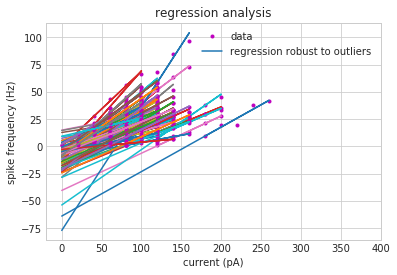

In [112]:
All_Cells_Features_L4_re = cell_features(L4_re, L4_re_names)

In [113]:
All_Cells_Features_L4_re.to_csv('../L4/ReAnalysis/WithRheobaseAndSag/L4Data/Cell_Features_L4.csv')

In [59]:
All_Cells_Features_L4_excluded = cell_features(L4_excluded, L4_excluded_names)
All_Cells_Features_L4_excluded.to_csv('../L4/ReAnalysis/L4Data/Cell_Features_L4_excluded.csv')

Processing:  ../L4/ReAnalysis/data/Excluded Data//2018 03 07 slice 1 sample 8 (matinotti V1 not good quality).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/Excluded Data//2018 06 06 slice 1 sample 1.mat
Processing:  ../L4/ReAnalysis/data/Excluded Data//2018 03 07 slice 1 sample 2 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/Excluded Data//2018 05 06 slice 1 sample 4 (martinotti V1).mat
Processing:  ../L4/ReAnalysis/data/Excluded Data//2018 03 07 slice 1 sample 14 (fast spiking S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/Excluded Data//2018 19 09 slice 1 sample 1 (matinotti V1).mat
Processing:  ../L4/ReAnalysis/data/Excluded Data//2018 05 06 slice 1 sample 17 (fast spiking S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/Excluded Data//2018 03 07 slice 1 sample 14 (non-martinotti S1 not sure layer).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/Excluded Data//2018 26 06 slice 1 sample 2 (non-martinoti S1).mat
Processing:  ../L4/ReAnalysis/data/Excluded Data//2018 04 06 slice 1 sample 3 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../L4/ReAnalysis/data/Excluded Data//2018 26 06 slice 1 sample 7 (non-martinoti S1).mat


# Plotting information as a sanity check

In [97]:
def prel_inspection(data):
    """ Plots the voltage traces for some current steps ment for quality checks and preliminary inspection
    Parameters
    ----------
    data : data full of voltage (V) and time (s) for a particular cell
    
    Returns
    -------
    ax : figure object
    
    """
    time, current, voltage, curr_index_0 = data_preparation(data)
    f, ax = plt.subplots(figsize = (10, 10))
    plt.plot(time, voltage[:, ::4])
    plt.xlabel('Time (s)')
    plt.ylabel('Membrane voltage (mV)')
    
    return ax

In [98]:
def prel_inspection_all(data_tuple, names, directory):
    """ Plots info of the first spike train (with more than 3 peaks)
    Parameters
    ----------
    data_tuple : tuple of dictionaries of data full of voltage (V) and time (s) traces for different cells
    names : tuple of names of the samples
    directory : directory where to output the figures
    
    Saves
    -------
    Figures in specified directory
    """
    for (data, name) in zip(data_tuple, names):
        print('Processing: ', name)
        time, current, voltage, curr_index_0 = data_preparation(data)
        ax = prel_inspection(data)
        plt.title(name.split('/')[-1].split('.')[0], fontsize = 25)
        plt.savefig('{}{}.png'.format(directory, name.split('/')[-1].split('.')[0]), bbox_inches = 'tight', \
                                                                                     pad_inches = 0.5)
        plt.close()

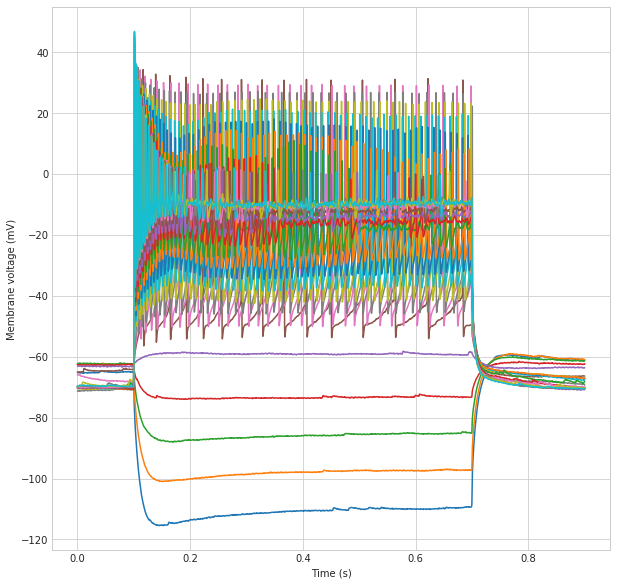

In [341]:
prel_inspection(data_NMC_1)

In [114]:
directory = '../L4/ReAnalysis/WithRheobaseAndSag/Figures/PrelInspection/'
prel_inspection_all(L4_re, L4_re_names, directory)

Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 21 09 slice 1 sample 6 (non-martinotti S1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 26 06 slice 1 sample 15 (non-martinotti S1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 26 06 slice 1 sample 16 (non-martinotti S1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 26 06 slice 1 sample 8 (non-martinotti S1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 21 09 slice 1 sample 8 (non-martinotti S1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 26 06 slice 1 sample 6 (non-martinotti S1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 05 06 slice 1 sample 16 (non-martinotti S1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 27 06 slice 1 sample 9 (non-martinotti S1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 19 09 slice 2 sample 23 (no

Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 19 09 slice 1 sample 4 (martinotti V1).mat
Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 19 09 slice 1 sample 3 (martinotti V1).mat
Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 26 06 slice 1 sample 11 (martinotti V1).mat
Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 20 09 slice 1 sample 5 (martinotti V1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 5/2018 27 06 slice 1 sample 2 (layer 5 S1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 5/2018 27 06 slice 1 sample 10 (layer 5 S1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 5/2018 05 07 slice 1 sample 10 (layer 5 S1) no good cell close.mat
Processing:  ../L4/ReAnalysis/data/S1 layer 5/2018 27 06 slice 1 sample 4 (layer 5 S1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 5/2018 26 06 slice 1 sample 9 (layer 5 S1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 5/2018 03 07 slice 1 sample 12 (layer 5 S1).mat
Processing:

In [38]:
def plot_info(data, start = 0.1, end = 0.7):
    """ Analyses a specific data dictionary corresponding to a cell and returns a figure object with annotations on a particular
    trace of how certain features have been calculated.
    Parameters
    ----------
    data : data full of voltage (V) and time (s) for a particular cell
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    start : start of the stimulation (s) in the voltage trace (optional, default 0.1)
    end : end of the stimulation (s) in the voltage trace (optional, default 0.7)
    fil : cutoff frequency for 4-pole low-pass Bessel filter in kHz (optional, default 10)
    
    Returns
    -------
    ax : figure object
    """
    time, current, voltage, curr_index_0 = data_preparation(data)
    filter_ = 10
    if (1/time[1]-time[0]) < 20e3:
        filter_ = (1/time[1]-time[0])/(1e3*2)-0.5
    df, df_related_features = extract_spike_features(time, current, voltage, fil = filter_)
    Cell_Features = get_cell_features(df, df_related_features, curr_index_0)
    
    # First current magnitude (starting from the lowest absolute current stimulation magnitude value) where we find more than
    # three spikes
    current_first = np.flatnonzero(df_related_features['spike_count'].values >=3)[0]
    
    f, ax = plt.subplots(figsize = (10, 10))
    ax.plot(time, voltage[:, current_first])
    
    # Actual current there
    current_first_magn = current[current_first]
    # Amount of spikes there
    spike_count = df_related_features['spike_count'].values[current_first]
    
    
    # Find start and end indexes in df for all the spikes in that particular train
    index_start_df = np.flatnonzero(df['threshold_i'].values >= current_first_magn)[0]
    index_end_df = np.flatnonzero(df['threshold_i'].values >= current_first_magn)[0] + spike_count
    # When last spike is clipped
    if df['clipped'].values[index_end_df-1]:
        index_end_df = np.flatnonzero(df['threshold_i'].values >= \
                                        current_first_magn)[0] + (spike_count - 1)
    # When the spike before the last spike is also clipped
    if df['clipped'].values[index_end_df-1]:
        index_end_df = np.flatnonzero(df['threshold_i'].values >= \
                                        current_first_magn)[0] + (spike_count - 2)
    
    # Get threshold, peak, upstroke and downstroke indexes
    thresh_index = np.array(df['threshold_index'].values[index_start_df : index_end_df], dtype = int)
    upstroke_index = np.array(df['upstroke_index'].values[index_start_df : index_end_df], dtype = int)
    peak_index = np.array(df['peak_index'].values[index_start_df : index_end_df], dtype = int)
    downstroke_index = np.array(df['downstroke_index'].values[index_start_df : index_end_df], dtype = int)
    fast_trough_index = np.array(df['fast_trough_index'].values[index_start_df : index_end_df], dtype = int)
    fast_trough_index = np.array(fast_trough_index[~np.isnan(fast_trough_index)], dtype = int)
    slow_trough_index = df['slow_trough_index'].values[index_start_df : index_end_df]
    slow_trough_index = np.array(slow_trough_index[~np.isnan(slow_trough_index)], dtype = int)
    
    start_index = (np.abs(time - start/10)).argmin() # Find closest index where the injection current starts (quite a bit before now)
    end_index = (np.abs(time - end)).argmin() # Find closest index where the injection current ends
    
    ax.plot(time[np.abs(time - start/2).argmin()], Cell_Features['Rm (mV)'], 'C0.', ms = 15)
    ax.plot(time[thresh_index], voltage[thresh_index, current_first], 'b.', ms = 15)
    ax.plot(time[upstroke_index], voltage[upstroke_index, current_first], 'r.', ms = 15)
    ax.plot(time[peak_index], voltage[peak_index, current_first], 'g.', ms = 15)
    ax.plot(time[downstroke_index], voltage[downstroke_index, current_first], 'k.', ms = 15)
    ax.plot(time[fast_trough_index], voltage[fast_trough_index, current_first], 'y.', ms = 15)
    ax.plot(time[slow_trough_index], voltage[slow_trough_index, current_first], 'm.', ms = 15)
    ax.set_xlim([time[start_index], time[end_index]])
    ax.set_xlabel('Time (s)', fontsize = 15)
    ax.set_ylabel('Voltage (mV)', fontsize = 15)
    ax.set_title('Voltage trace in function of time with annotations', fontsize = 25)
    ax.legend(['Trace', 'Resting Vm', 'Threshold', 'Upstroke', 'Peak', 'Downstroke', 'Fast trough', \
               'Slow trough (if applicable)'], fontsize = 15, loc='upper left', bbox_to_anchor=(1, 1))
    
    # Nice annotations
    if len(thresh_index) > 2 :
        ax.plot(time[thresh_index[0:3]], voltage[thresh_index[0:3], current_first], '|', color = 'black', ms = 200)
        ax.annotate('', xy = (time[thresh_index[0]], voltage[thresh_index[0], current_first] - 10), \
                xycoords = 'data', xytext = (time[thresh_index[1]], voltage[thresh_index[0], current_first] - 10), \
                textcoords = 'data', arrowprops = {'arrowstyle': '<->', 'connectionstyle': 'arc3', 'lw': 0.5, 'shrinkA': 0})
        ax.annotate('', xy = (time[thresh_index[1]], voltage[thresh_index[0], current_first] - 10), \
                xycoords = 'data', xytext = (time[thresh_index[2]], voltage[thresh_index[0], current_first] - 10), \
                textcoords = 'data', arrowprops = {'arrowstyle': '<->', 'connectionstyle': 'arc3', 'lw': 0.5, 'shrinkA': 0})
        plt.annotate('AI = (2e ISI / 1e ISI)*100', xy=(time[thresh_index[1]], voltage[thresh_index[1], current_first]-30), \
                 xycoords='data', xytext=(5, 0), textcoords='offset points', fontsize = 15)
    return ax

In [39]:
def plot_info_all(data_tuple, names, directory, el_num = 2, current_step = 20):
    """ Plots info of the first spike train (with more than 3 peaks)
    Parameters
    ----------
    data_tuple : tuple of dictionaries of data full of voltage (V) and time (s) traces for different cells
    names : tuple of names of the samples
    directory : directory where to output the figures
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    
    Saves
    -------
    Figures in specified directory
    """
    for (data, name) in zip(data_tuple, names):
        print('Processing: ', name)
        time, current, voltage, curr_index_0 = data_preparation(data)
        filter_ = 10
        if (1/time[1]-time[0]) < 20e3:
            filter_ = (1/time[1]-time[0])/(1e3*2)-0.5
        df, df_related_features = extract_spike_features(time, current, voltage)
        if ~np.any(df_related_features['spike_count'] >= 3):         # There might be no traces with more than 3 spikes
                                                                     # whatsoever
            continue
        ax = plot_info(data)
        plt.title(name.split('/')[-1].split('.')[0], fontsize = 25)
        plt.savefig('{}{}.png'.format(directory, name.split('/')[-1].split('.')[0]), bbox_inches = 'tight', \
                                                                                     pad_inches = 0.5)
        plt.close()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


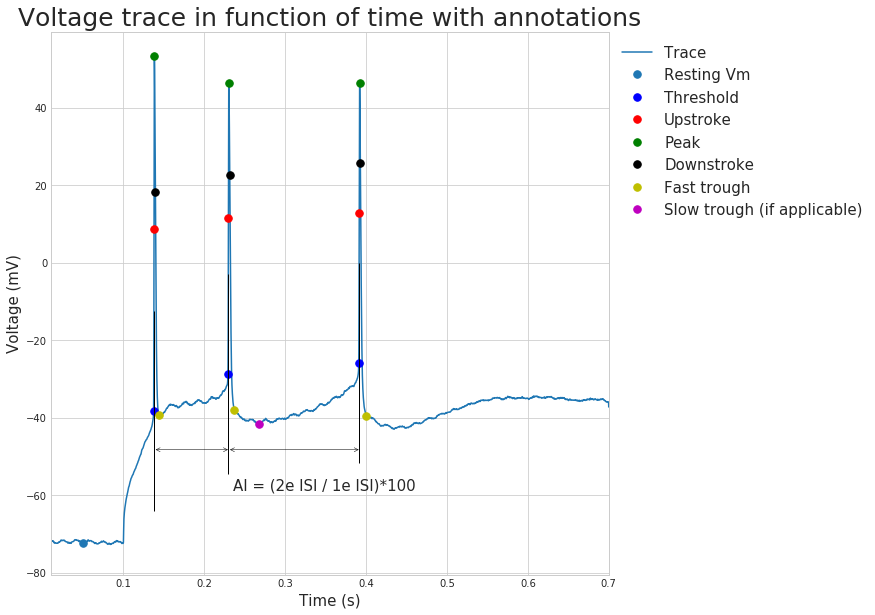

In [356]:
plot_info(data_plot)

In [49]:
directory = '../L4/ReAnalysis/Figures/PlotInfoMultiplePeaks/'
plot_info_all(L4_re, L4_re_names, directory)

Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 21 09 slice 1 sample 6 (non-martinotti S1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 26 06 slice 1 sample 15 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 26 06 slice 1 sample 16 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 26 06 slice 1 sample 8 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 21 09 slice 1 sample 8 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 26 06 slice 1 sample 6 (non-martinotti S1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 05 06 slice 1 sample 16 (non-martinotti S1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 27 06 slice 1 sample 9 (non-martinotti S1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 19 09 slice 2 sample 23 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 20 09 slice 1 sample 9 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 19 09 slice 2 sample 14 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 19 09 slice 2 sample 20 (non-martinotti S1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 05 06 slice 1 sample 14 (non-martinotti S1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 21 09 slice 1 sample 4 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 21 09 slice 1 sample 5 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 19 09 slice 2 sample 18 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 19 09 slice 2 sample 24 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 19 09 slice 2 sample 22 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 05 06 slice 1 sample 15 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 19 09 slice 2 sample 19 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 21 09 slice 1 sample 2 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 20 09 slice 1 sample 10 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 26 06 slice 1 sample 17 (non-martinotti S1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 19 09 slice 2 sample 21 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 27 06 slice 1 sample 8 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 03 07 slice 1 sample 11 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 27 06 slice 1 sample 3 (non-martinotti S1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 19 09 slice 1 sample 7 (non-martinotti S1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 21 09 slice 1 sample 1 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 03 07 slice 1 sample 7 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 05 06 slice 1 sample 18 (non-martinotti S1).mat
Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 19 09 slice 1 sample 10 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 20 09 slice 1 sample 4 (martinotti V1).mat
Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 05 06 slice 1 sample 13 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 03 07 slice 1 sample 15 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 26 06 slice 1 sample 13 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 19 09 slice 1 sample 11 (martinotti V1).mat
Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 19 09 slice 2 sample 13 (martinotti V1).mat
Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 20 09 slice 1 sample 3 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 19 09 slice 2 sample 16 (martinotti V1).mat
Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 04 06 slice 1 sample 2 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 05 06 slice 1 sample 5 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 26 06 slice 1 sample 12 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 19 09 slice 1 sample 2 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 20 09 slice 1 sample 2 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 05 06 slice 1 sample 19 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 04 06 slice 1 sample 1 (martinotti V1).mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 05 06 slice 1 sample 2 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 05 06 slice 1 sample 7 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 19 09 slice 1 sample 6 (martinotti V1).mat
Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 03 07 slice 1 sample 3 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 19 09 slice 2 sample 25 (martinotti V1).mat
Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 20 09 slice 1 sample 1 (martinotti V1).mat
Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 05 06 slice 1 sample 10 (martinotti V1).mat
Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 05 06 slice 1 sample 6 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 19 09 slice 1 sample 4 (martinotti V1).mat
Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 26 06 slice 1 sample 2 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 19 09 slice 1 sample 3 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 26 06 slice 1 sample 11 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 20 09 slice 1 sample 5 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


In [54]:
directory = '../L4/ReAnalysis/Figures/PlotInfoMultiplePeaksExcludedData/'
plot_info_all(L4_excluded, L4_excluded_names, directory)

Processing:  ../L4/ReAnalysis/data/Excluded Data//2018 06 06 slice 1 sample 1.mat
Processing:  ../L4/ReAnalysis/data/Excluded Data//2018 03 07 slice 1 sample 2 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/Excluded Data//2018 03 07 slice 1 sample 14 (non-martinotti S1; not sure layer).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/Excluded Data//2018 05 06 slice 1 sample 4 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/Excluded Data//2018 03 07 slice 1 sample 14 (fast spiking S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/Excluded Data//2018 19 09 slice 1 sample 1 (matinotti V1).mat
Processing:  ../L4/ReAnalysis/data/Excluded Data//2018 05 06 slice 1 sample 17 (fast spiking S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/Excluded Data//2018 26 06 slice 1 sample 2 (non-martinoti S1).mat
Processing:  ../L4/ReAnalysis/data/Excluded Data//2018 04 06 slice 1 sample 3 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../L4/ReAnalysis/data/Excluded Data//2018 26 06 slice 1 sample 7 (non-martinoti S1).mat
Processing:  ../L4/ReAnalysis/data/Excluded Data//2018 03 07 slice 1 sample 8 (matinotti V1; not good quality).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


In [42]:
def plot_info_first_peak(data, start = 0.1, end = 0.7):
    """ Analyses a specific data dictionary corresponding to a cell and returns a figure object with annotations on the first
    peak of a particular trace of how certain features have been calculated. Works for data extracted from .mat files, not for
    .asc files.
    Parameters
    ----------
    data : data full of voltage (V) and time (s) for a particular cell
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    start : start of the stimulation (s) in the voltage trace (optional, default 0.1)
    end : end of the stimulation (s) in the voltage trace (optional, default 0.7)
    fil : cutoff frequency for 4-pole low-pass Bessel filter in kHz (optional, default 10)
    
    Returns
    -------
    ax : figure object
    """
    time, current, voltage, curr_index_0 = data_preparation(data)
    filter_ = 10
    if (1/time[1]-time[0]) < 20e3:
        filter_ = (1/time[1]-time[0])/(1e3*2)-0.5
    df, df_related_features = extract_spike_features(time, current, voltage)
    Cell_Features = get_cell_features(df, df_related_features, curr_index_0)
    current_first = np.flatnonzero(df_related_features['spike_count'].values >=1)[0]


    # Actual current there
    current_first_magn = current[current_first]
    # Amount of spikes there
    spike_count = df_related_features['spike_count'].values[current_first]


    # Find start and end indexes in df for all the spikes in that particular train
    index_start_df = np.flatnonzero(df['threshold_i'].values >= \
    current_first_magn)[0]
    index_end_df = np.flatnonzero(df['threshold_i'].values >= \
    current_first_magn)[0] + spike_count

    # Get threshold, peak, upstroke and downstroke indexes
    thresh_index = np.array(df['threshold_index'].values[index_start_df : index_end_df], dtype = int)
    upstroke_index = np.array(df['upstroke_index'].values[index_start_df : index_end_df], dtype = int)
    peak_index = np.array(df['peak_index'].values[index_start_df : index_end_df], dtype = int)
    downstroke_index = np.array(df['downstroke_index'].values[index_start_df : index_end_df], dtype = int)
    fast_trough_index = np.array(df['fast_trough_index'].values[index_start_df : index_end_df], dtype = int)
    slow_trough_index = df['slow_trough_index'].values[index_start_df : index_end_df]
    slow_trough_index = np.array(slow_trough_index[~np.isnan(slow_trough_index)], dtype = int)

    
    start_index = thresh_index[0]
    end_index = fast_trough_index[0] + 50 # Plot 50 time indices after the fast trough index (should always exist)
        # When last spike is clipped
    if df['clipped'].values[index_end_df-1]:
        return

    f, ax = plt.subplots(figsize = (10, 10))
    ax.plot(time[start_index : end_index], voltage[start_index : end_index, current_first])

    ax.plot(time[thresh_index[0]], voltage[thresh_index[0], current_first], 'b.', ms = 15)
    ax.plot(time[upstroke_index[0]], voltage[upstroke_index[0], current_first], 'r.', ms = 15)
    ax.plot(time[peak_index[0]], voltage[peak_index[0], current_first], 'g.', ms = 15)
    ax.plot(time[downstroke_index[0]], voltage[downstroke_index[0], current_first], 'k.', ms = 15)
    ax.plot(time[fast_trough_index[0]], voltage[fast_trough_index[0], current_first], 'y.', ms = 15)
    if slow_trough_index.size:
        ax.plot(time[slow_trough_index[0]], voltage[slow_trough_index[0], current_first], 'm.')
        ax.legend(['Trace', 'Threshold', 'Upstroke', 'Peak', 'Downstroke', 'Fast trough', 'Slow trough (if applicable)'])
    else:
        ax.legend(['Trace', 'Threshold', 'Upstroke', 'Peak', 'Downstroke', 'Fast trough'])
    ax.set_xlabel('Time (s)', fontsize = 15)
    ax.set_ylabel('Voltage (mV)', fontsize = 15)
    ax.set_title('First peak annotations (voltage i.f.o. time)', fontsize = 25)

    # Nice annotations

    ax.annotate('', xy = (time[peak_index[0]], voltage[peak_index[0], current_first]), \
                xycoords = 'data', xytext = (time[peak_index[0]], voltage[thresh_index[0], current_first]), \
                textcoords = 'data', arrowprops = {'arrowstyle': '<->', 'connectionstyle': 'arc3', 'lw': 4, 'shrinkB': 0})
    ax.plot(time[peak_index[0]], voltage[thresh_index[0], current_first], '_', color = 'black', ms = 100)
    ax.plot(time[peak_index[0]], voltage[peak_index[0], current_first], '_', color = 'black', ms = 100)


    width_level = (voltage[peak_index[0], current_first] - voltage[thresh_index[0], current_first])/2 + \
                   voltage[thresh_index[0], current_first]
    width_start_index = peak_index[0] - np.flatnonzero(voltage[peak_index[0] : thresh_index[0]:-1, current_first] <= width_level)[0]
    width_end_index = peak_index[0] + np.flatnonzero(voltage[peak_index[0]: fast_trough_index[0], current_first] <=width_level)[0]
    plt.plot(time[width_start_index], voltage[width_start_index, current_first], '|', color = 'black', ms = 100)
    plt.plot(time[width_end_index], voltage[width_end_index, current_first], '|', color = 'black', ms = 100)

    # The half-width itself is calculated based on t[width_end_index] - t[width_start_index], but the voltages might be different
    # at the respective indices, thus we choose the arrow to go from v[width_start_index] to v[width_start_index] to make
    # it horizontal (interpretability of the figure improves)
    ax.annotate('', xy = (time[width_start_index], voltage[width_start_index, current_first]), \
                xycoords = 'data', xytext = (time[width_end_index], voltage[width_start_index, current_first]), \
                textcoords = 'data', arrowprops = {'arrowstyle': '<->', 'connectionstyle': 'arc3', 'lw': 4, 'shrinkA': 0})
    ax.annotate('AP half-width', xy = (time[width_start_index], \
                 width_level - 5), xycoords='data', xytext = (5, 0), textcoords = 'offset points', fontsize = 15)

    # For the AP amplitude
    ax.annotate('AP amplitude', xy = (time[peak_index[0]], width_level + 20), \
                 xycoords = 'data', xytext = (5, 0), textcoords = 'offset points', fontsize = 15)
    
    return ax

In [43]:
def plot_info_first_peak_all(data_tuple, names, directory, el_num = 2, current_step = 20):
    """ Plots info of the first spike train (with more than 3 peaks)
    Parameters
    ----------
    data_tuple : tuple of dictionaries of data full of voltage (V) and time (s) traces for different cells
    names : tuple of names of the samples
    directory : directory where to output the figures
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    
    Saves
    -------
    Figures in specified directory
    """
    for (data, name) in zip(data_tuple, names):
        print('Processing: ', name)
        time, current, voltage, curr_index_0 = data_preparation(data)
        filter_ = 10
        if (1/time[1]-time[0]) < 20e3:
            filter_ = (1/time[1]-time[0])/(1e3*2)-0.5
        df, df_related_features = extract_spike_features(time, current, voltage)
        if ~np.any(df_related_features['spike_count'] >= 1):
            continue
        ax = plot_info_first_peak(data)
        plt.title(name.split('/')[-1].split('.')[0], fontsize = 25)
        plt.savefig('{}{}.png'.format(directory, name.split('/')[-1].split('.')[0]), bbox_inches = 'tight', \
                                                                                     pad_inches = 0.5)
        plt.close()

In [50]:
directory = '../L4/ReAnalysis/Figures/PlotInfoFirstPeak/'
plot_info_first_peak_all(L4_re, L4_re_names, directory)

Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 21 09 slice 1 sample 6 (non-martinotti S1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 26 06 slice 1 sample 15 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 26 06 slice 1 sample 16 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 26 06 slice 1 sample 8 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 21 09 slice 1 sample 8 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 26 06 slice 1 sample 6 (non-martinotti S1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 05 06 slice 1 sample 16 (non-martinotti S1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 27 06 slice 1 sample 9 (non-martinotti S1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 19 09 slice 2 sample 23 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 20 09 slice 1 sample 9 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 19 09 slice 2 sample 14 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 19 09 slice 2 sample 20 (non-martinotti S1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 05 06 slice 1 sample 14 (non-martinotti S1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 21 09 slice 1 sample 4 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 21 09 slice 1 sample 5 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 19 09 slice 2 sample 18 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 19 09 slice 2 sample 24 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 19 09 slice 2 sample 22 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 05 06 slice 1 sample 15 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 19 09 slice 2 sample 19 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 21 09 slice 1 sample 2 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 20 09 slice 1 sample 10 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 26 06 slice 1 sample 17 (non-martinotti S1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 19 09 slice 2 sample 21 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 27 06 slice 1 sample 8 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 03 07 slice 1 sample 11 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 27 06 slice 1 sample 3 (non-martinotti S1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 19 09 slice 1 sample 7 (non-martinotti S1).mat
Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 21 09 slice 1 sample 1 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 03 07 slice 1 sample 7 (non-martinotti S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/S1 layer 4 non Martinotti/2018 05 06 slice 1 sample 18 (non-martinotti S1).mat
Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 19 09 slice 1 sample 10 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 20 09 slice 1 sample 4 (martinotti V1).mat
Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 05 06 slice 1 sample 13 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 03 07 slice 1 sample 15 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 26 06 slice 1 sample 13 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 19 09 slice 1 sample 11 (martinotti V1).mat
Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 19 09 slice 2 sample 13 (martinotti V1).mat
Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 20 09 slice 1 sample 3 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 19 09 slice 2 sample 16 (martinotti V1).mat
Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 04 06 slice 1 sample 2 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 05 06 slice 1 sample 5 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 26 06 slice 1 sample 12 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 19 09 slice 1 sample 2 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 20 09 slice 1 sample 2 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 05 06 slice 1 sample 19 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 04 06 slice 1 sample 1 (martinotti V1).mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 05 06 slice 1 sample 2 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 05 06 slice 1 sample 7 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 19 09 slice 1 sample 6 (martinotti V1).mat
Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 03 07 slice 1 sample 3 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 19 09 slice 2 sample 25 (martinotti V1).mat
Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 20 09 slice 1 sample 1 (martinotti V1).mat
Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 05 06 slice 1 sample 10 (martinotti V1).mat
Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 05 06 slice 1 sample 6 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 19 09 slice 1 sample 4 (martinotti V1).mat
Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 26 06 slice 1 sample 2 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 19 09 slice 1 sample 3 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 26 06 slice 1 sample 11 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/V1 layer 4 Martinotti/2018 20 09 slice 1 sample 5 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


In [55]:
directory = '../L4/ReAnalysis/Figures/PlotInfoFirstPeakExcludedData/'
plot_info_first_peak_all(L4_excluded, L4_excluded_names, directory)

Processing:  ../L4/ReAnalysis/data/Excluded Data//2018 06 06 slice 1 sample 1.mat
Processing:  ../L4/ReAnalysis/data/Excluded Data//2018 03 07 slice 1 sample 2 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../L4/ReAnalysis/data/Excluded Data//2018 03 07 slice 1 sample 14 (non-martinotti S1; not sure layer).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/Excluded Data//2018 05 06 slice 1 sample 4 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/Excluded Data//2018 03 07 slice 1 sample 14 (fast spiking S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/Excluded Data//2018 19 09 slice 1 sample 1 (matinotti V1).mat
Processing:  ../L4/ReAnalysis/data/Excluded Data//2018 05 06 slice 1 sample 17 (fast spiking S1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../L4/ReAnalysis/data/Excluded Data//2018 26 06 slice 1 sample 2 (non-martinoti S1).mat
Processing:  ../L4/ReAnalysis/data/Excluded Data//2018 04 06 slice 1 sample 3 (martinotti V1).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../L4/ReAnalysis/data/Excluded Data//2018 26 06 slice 1 sample 7 (non-martinoti S1).mat
Processing:  ../L4/ReAnalysis/data/Excluded Data//2018 03 07 slice 1 sample 8 (matinotti V1; not good quality).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
